## Curvefitting 4

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from IPython import display
import pandas as pd
from matplotlib import cm

## 1. Standard Polynomial Curvefitting

In [2]:
random_seed=6
n_points=10
noise_level=0.2

In [3]:
def f(x): return 0.5*(x**2)

all_x = np.linspace(-2, 2, 128)
all_y = f(all_x)

n_train_points=int(np.floor(n_points*0.5))
n_test_points=n_points-n_train_points
print(n_train_points, n_test_points)
                   
np.random.seed(random_seed) 
x=np.random.uniform(-2, 2, n_points)
y=f(x)+noise_level*np.random.randn(n_points)
x_train=x[:n_train_points]
y_train=y[:n_train_points]
x_test=x[n_train_points:]
y_test=y[n_train_points:]

x_train_tensor = torch.FloatTensor(x_train).reshape(-1, 1)
y_train_tensor = torch.FloatTensor(y_train).reshape(-1, 1)
x_test_tensor = torch.FloatTensor(x_test).reshape(-1, 1)
y_test_tensor = torch.FloatTensor(y_test).reshape(-1, 1)

5 5


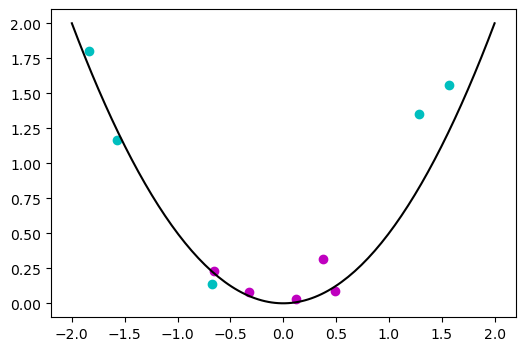

In [4]:
fig=plt.figure(0, (6, 4))
plt.plot(all_x, all_y, c='k')
plt.scatter(x_train, y_train, c='c')
plt.scatter(x_test, y_test, c='m')
# plt.ylim([-0.5, 2])

/var/folders/w_/_4hnpxr91r78y8gdhv58zlrm0000gn/T/ipykernel_17070/932349376.py:18: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(x_train, y_train, degree)
/var/folders/w_/_4hnpxr91r78y8gdhv58zlrm0000gn/T/ipykernel_17070/932349376.py:18: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(x_train, y_train, degree)


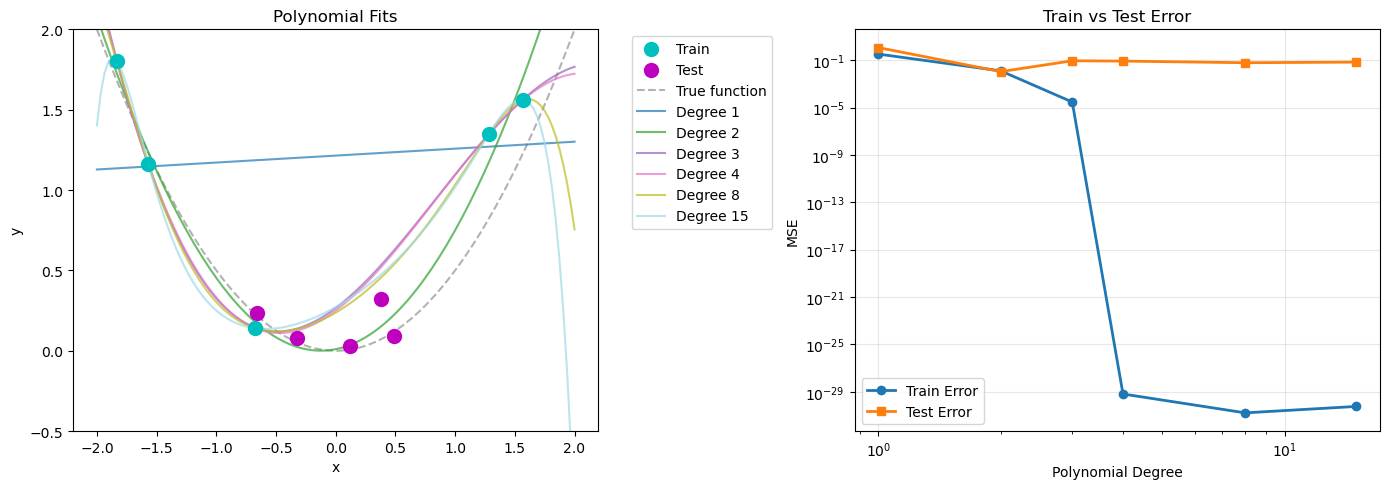

Degree   1: Train MSE = 0.324305, Test MSE = 1.145866
Degree   2: Train MSE = 0.012458, Test MSE = 0.010725
Degree   3: Train MSE = 0.000029, Test MSE = 0.088361
Degree   4: Train MSE = 0.000000, Test MSE = 0.083069
Degree   8: Train MSE = 0.000000, Test MSE = 0.060561
Degree  15: Train MSE = 0.000000, Test MSE = 0.068159


In [5]:
degrees = [1, 2, 3, 4, 8, 15] #6, 7, 8, 10, 20, 30, 50, 100]
train_errors = []
test_errors = []

# Get colormap
colors = cm.tab20(np.linspace(0, 1, len(degrees)))

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Left subplot: fits
ax1.scatter(x_train, y_train, c='c', s=100, label='Train', zorder=10)
ax1.scatter(x_test, y_test, c='m', s=100, label='Test', zorder=10)
ax1.plot(all_x, all_y, 'k--', alpha=0.3, label='True function')

for i, degree in enumerate(degrees):
    # Fit polynomial
    coefficients = np.polyfit(x_train, y_train, degree)
    all_y_fit = np.polyval(coefficients, all_x)
    
    # Plot fit
    ax1.plot(all_x, all_y_fit, color=colors[i], label=f'Degree {degree}', alpha=0.7)
    
    # Calculate errors
    y_train_pred = np.polyval(coefficients, x_train)
    y_test_pred = np.polyval(coefficients, x_test)
    train_error = np.mean((y_train - y_train_pred)**2)
    test_error = np.mean((y_test - y_test_pred)**2)
    train_errors.append(train_error)
    test_errors.append(test_error)

ax1.set_ylim([-0.5, 2])
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_title('Polynomial Fits')
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Right subplot: errors
ax2.plot(degrees, train_errors, 'o-', label='Train Error', linewidth=2)
ax2.plot(degrees, test_errors, 's-', label='Test Error', linewidth=2)
ax2.set_xlabel('Polynomial Degree')
ax2.set_ylabel('MSE')
ax2.set_title('Train vs Test Error')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print errors
for degree, train_err, test_err in zip(degrees, train_errors, test_errors):
    print(f"Degree {degree:3d}: Train MSE = {train_err:.6f}, Test MSE = {test_err:.6f}")

- Ok so I might want to noodle some more on the random init/number of points etc - but this looks ok for now!
- There's also a chance that the actual example from the book works - that could be cool, we'll see!
- I'm also kinda fuzzy on the advantages/disadvantages of doing like 3-5 points vs like 16. 

## Show that multiple solutions fit the data beyond the interpolation threshold. 

Min norm train error: 3.65e-30
Null space 1 train error: 3.44e-30, test error: 1.7030
Null space 2 train error: 2.54e-30, test error: 1.4169
Null space 3 train error: 2.41e-30, test error: 0.2642
Null space 4 train error: 6.57e-30, test error: 1.7560
Null space 5 train error: 9.28e-31, test error: 0.0281


/var/folders/w_/_4hnpxr91r78y8gdhv58zlrm0000gn/T/ipykernel_17070/2921489821.py:4: RankWarning: Polyfit may be poorly conditioned
  return np.polyfit(x, y, degree)


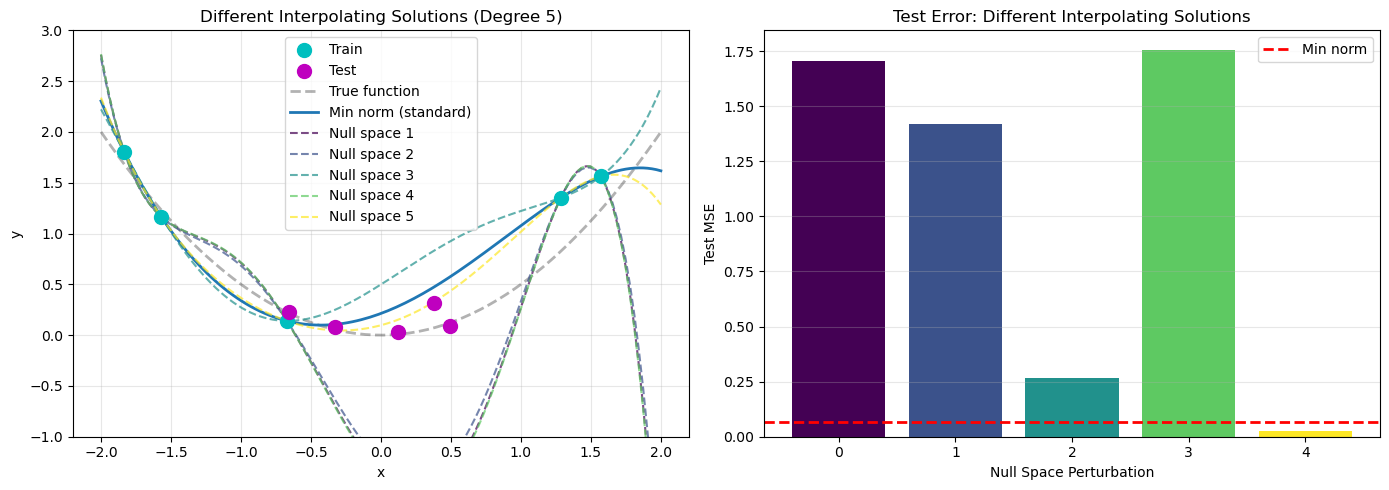


For degree 5 polynomial with 5 training points:
Number of parameters: 6
Degrees of freedom in null space: 1


In [6]:
# Method 1: Minimum norm solution (pseudoinverse)
def fit_min_norm(x, y, degree):
    """Standard least squares / minimum norm solution"""
    return np.polyfit(x, y, degree)

# Method 2: Add random perturbations to null space (CORRECTED)
def fit_random_nullspace(x, y, degree, scale=1.0, seed=None):
    """Add random component from the null space - still interpolates!"""
    if seed is not None:
        np.random.seed(seed)
    
    # Get minimum norm solution using pseudoinverse
    X = np.vander(x, degree + 1, increasing=True)  # Features: [1, x, x^2, ...]
    coeffs_min = np.linalg.lstsq(X, y, rcond=None)[0]
    
    # Find null space of X
    U, S, Vt = np.linalg.svd(X, full_matrices=True)
    # Null space is spanned by rows of Vt corresponding to zero singular values
    rank = np.sum(S > 1e-10)
    null_space = Vt[rank:, :]
    
    if null_space.shape[0] > 0:
        # Add random combination of null space vectors
        random_weights = np.random.randn(null_space.shape[0])
        null_component = scale * (random_weights @ null_space)
        coeffs = coeffs_min + null_component
    else:
        coeffs = coeffs_min
    
    return coeffs[::-1]  # Reverse to match numpy's polyval order (high to low degree)

# Let's visualize different interpolating solutions
degree = 5
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Different interpolating solutions
ax1.scatter(x_train, y_train, c='c', s=100, label='Train', zorder=10)
ax1.scatter(x_test, y_test, c='m', s=100, label='Test', zorder=10)
ax1.plot(all_x, all_y, 'k--', alpha=0.3, label='True function', linewidth=2)

# Minimum norm
coeffs_min = fit_min_norm(x_train, y_train, degree)
ax1.plot(all_x, np.polyval(coeffs_min, all_x), label='Min norm (standard)', linewidth=2)

# Verify it interpolates
y_train_pred = np.polyval(coeffs_min, x_train)
print(f"Min norm train error: {np.mean((y_train - y_train_pred)**2):.2e}")

# Random null space perturbations - all should interpolate!
colors_null = cm.viridis(np.linspace(0, 1, 5))
test_errors_null = []

for i in range(5):
    coeffs_null = fit_random_nullspace(x_train, y_train, degree, scale=2.0, seed=i)
    ax1.plot(all_x, np.polyval(coeffs_null, all_x), 
             color=colors_null[i], label=f'Null space {i+1}', alpha=0.7, linestyle='--')
    
    # Verify it interpolates
    y_train_pred = np.polyval(coeffs_null, x_train)
    train_error = np.mean((y_train - y_train_pred)**2)
    
    # Calculate test error
    y_test_pred = np.polyval(coeffs_null, x_test)
    test_error = np.mean((y_test - y_test_pred)**2)
    test_errors_null.append(test_error)
    
    print(f"Null space {i+1} train error: {train_error:.2e}, test error: {test_error:.4f}")

ax1.set_ylim([-1, 3])
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_title(f'Different Interpolating Solutions (Degree {degree})')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Test errors for different null space perturbations
ax2.bar(range(len(test_errors_null)), test_errors_null, color=colors_null)
ax2.axhline(y=np.mean((y_test - np.polyval(coeffs_min, x_test))**2), 
            color='r', linestyle='--', linewidth=2, label='Min norm')
ax2.set_xlabel('Null Space Perturbation')
ax2.set_ylabel('Test MSE')
ax2.set_title('Test Error: Different Interpolating Solutions')
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"\nFor degree {degree} polynomial with {n_train_points} training points:")
print(f"Number of parameters: {degree + 1}")
print(f"Degrees of freedom in null space: {max(0, degree + 1 - n_train_points)}")


Fitting degree 10 polynomial with gradient descent:
Training points: 5, Parameters: 11

Initialization 1:
  Step 0, Loss: 20026.792969
  Step 2000, Loss: 55.681641
  Step 4000, Loss: 2.373791
  Step 6000, Loss: 1.225344
  Step 8000, Loss: 0.257036
  Final train error: 0.017091, test error: 0.725784

Initialization 2:
  Step 0, Loss: 53667.054688
  Step 2000, Loss: 974.367004
  Step 4000, Loss: 31.754419
  Step 6000, Loss: 17.178978
  Step 8000, Loss: 7.065902
  Final train error: 1.212324, test error: 0.482921

Initialization 3:
  Step 0, Loss: 126647.273438
  Step 2000, Loss: 152.376419
  Step 4000, Loss: 103.765335
  Step 6000, Loss: 59.749683
  Step 8000, Loss: 16.407661
  Final train error: 2.610072, test error: 3.048993

Initialization 4:
  Step 0, Loss: 10852.334961
  Step 2000, Loss: 42.828602
  Step 4000, Loss: 16.842171
  Step 6000, Loss: 7.330550
  Step 8000, Loss: 1.864446
  Final train error: 0.147319, test error: 1.584576

Initialization 5:
  Step 0, Loss: 16411.404297
  

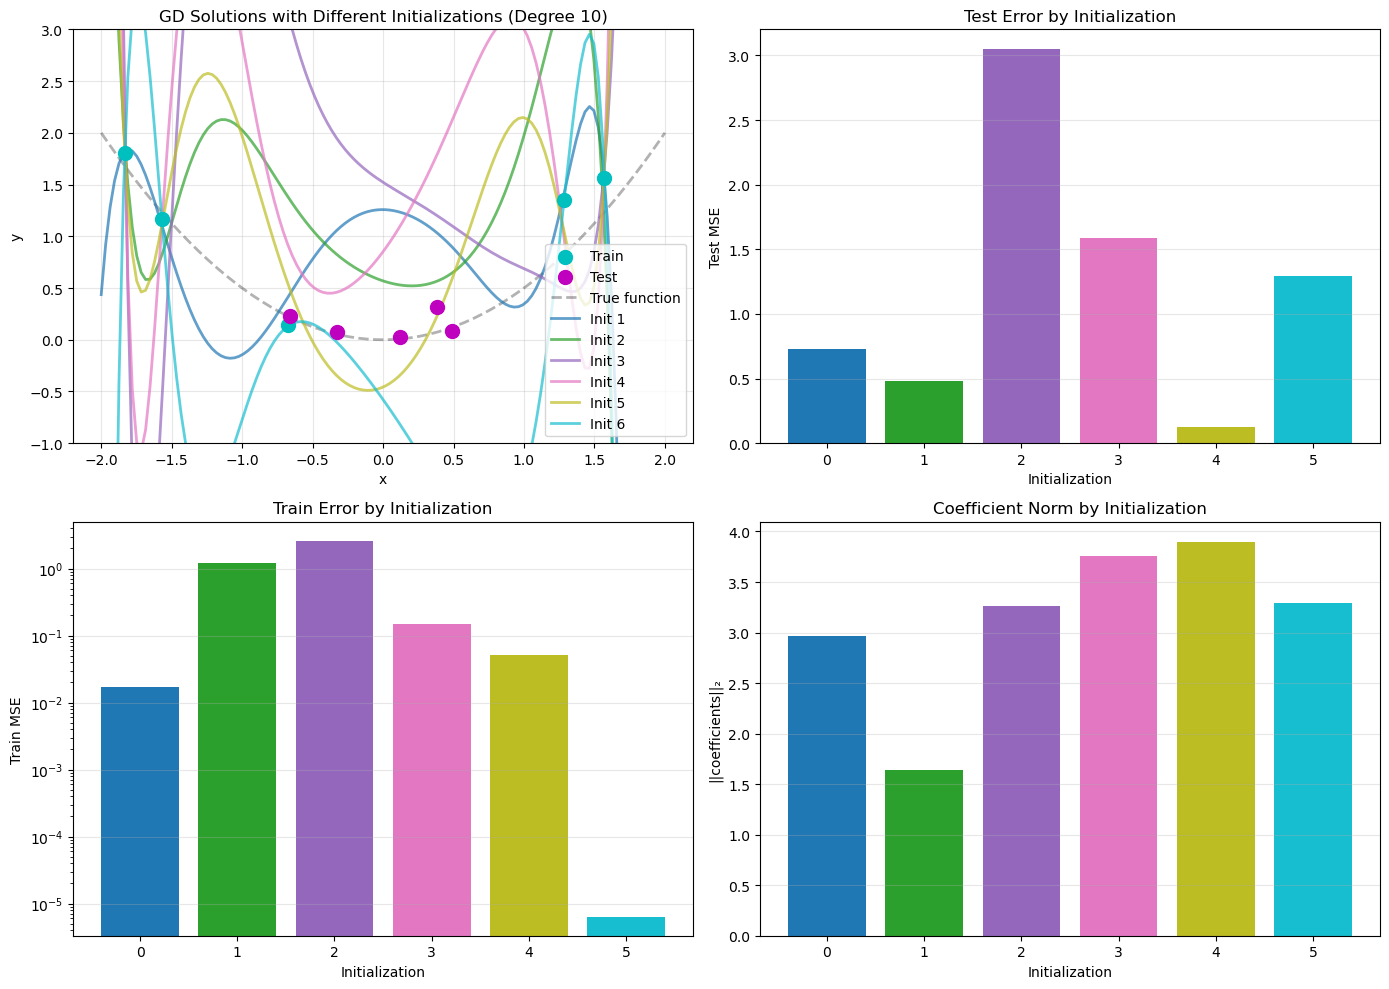

Min norm solution test error: 0.062015
Min norm coefficient norm: 0.6002


/var/folders/w_/_4hnpxr91r78y8gdhv58zlrm0000gn/T/ipykernel_17070/2921489821.py:4: RankWarning: Polyfit may be poorly conditioned
  return np.polyfit(x, y, degree)


In [7]:
import torch
import torch.nn as optim

def fit_polynomial_gd(x_tensor, y_tensor, degree, lr=0.01, steps=10000, init_scale=1.0, seed=None):
    """Fit polynomial using gradient descent with custom initialization"""
    if seed is not None:
        torch.manual_seed(seed)
    
    # Initialize coefficients randomly as a Parameter (leaf tensor)
    coeffs = torch.randn(degree + 1, 1) * init_scale
    coeffs = torch.nn.Parameter(coeffs)
    
    # Create Vandermonde matrix
    X = torch.cat([x_tensor**i for i in range(degree + 1)], dim=1)
    
    # Optimizer
    optimizer = torch.optim.Adam([coeffs], lr=lr)
    
    # Training loop
    for step in range(steps):
        optimizer.zero_grad()
        
        # Predictions
        y_pred = X @ coeffs
        
        # MSE loss
        loss = torch.mean((y_pred - y_tensor)**2)
        
        loss.backward()
        optimizer.step()
        
        # Print progress occasionally
        if step % 2000 == 0:
            print(f"  Step {step}, Loss: {loss.item():.6f}")
    
    return coeffs.detach().numpy().flatten()

def polyval_torch_coeffs(coeffs, x):
    """Evaluate polynomial with coefficients in increasing degree order"""
    result = np.zeros_like(x)
    for i, c in enumerate(coeffs):
        result += c * (x ** i)
    return result

# Experiment with different initializations
degree = 10
n_inits = 6

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 10))

# Plot setup
ax1.scatter(x_train, y_train, c='c', s=100, label='Train', zorder=10)
ax1.scatter(x_test, y_test, c='m', s=100, label='Test', zorder=10)
ax1.plot(all_x, all_y, 'k--', alpha=0.3, label='True function', linewidth=2)

# Store results
all_coeffs = []
train_errors = []
test_errors = []
colors = cm.tab10(np.linspace(0, 1, n_inits))

print(f"\nFitting degree {degree} polynomial with gradient descent:")
print(f"Training points: {n_train_points}, Parameters: {degree + 1}\n")

for i in range(n_inits):
    print(f"Initialization {i+1}:")
    
    # Fit with different random initialization
    coeffs = fit_polynomial_gd(
        x_train_tensor, y_train_tensor, 
        degree, 
        lr=0.001, 
        steps=10000,
        init_scale=1.0,
        seed=i
    )
    all_coeffs.append(coeffs)
    
    # Plot the fit
    y_fit = polyval_torch_coeffs(coeffs, all_x)
    ax1.plot(all_x, y_fit, color=colors[i], label=f'Init {i+1}', alpha=0.7, linewidth=2)
    
    # Calculate errors
    y_train_pred = polyval_torch_coeffs(coeffs, x_train)
    y_test_pred = polyval_torch_coeffs(coeffs, x_test)
    
    train_error = np.mean((y_train - y_train_pred)**2)
    test_error = np.mean((y_test - y_test_pred)**2)
    
    train_errors.append(train_error)
    test_errors.append(test_error)
    
    print(f"  Final train error: {train_error:.6f}, test error: {test_error:.6f}\n")

ax1.set_ylim([-1, 3])
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_title(f'GD Solutions with Different Initializations (Degree {degree})')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Test errors
ax2.bar(range(n_inits), test_errors, color=colors)
ax2.set_xlabel('Initialization')
ax2.set_ylabel('Test MSE')
ax2.set_title('Test Error by Initialization')
ax2.grid(True, alpha=0.3, axis='y')

# Plot 3: Train errors (should all be near zero if interpolating)
ax3.bar(range(n_inits), train_errors, color=colors)
ax3.set_xlabel('Initialization')
ax3.set_ylabel('Train MSE')
ax3.set_title('Train Error by Initialization')
ax3.set_yscale('log')
ax3.grid(True, alpha=0.3, axis='y')

# Plot 4: Coefficient magnitudes
coeff_norms = [np.linalg.norm(c) for c in all_coeffs]
ax4.bar(range(n_inits), coeff_norms, color=colors)
ax4.set_xlabel('Initialization')
ax4.set_ylabel('||coefficients||₂')
ax4.set_title('Coefficient Norm by Initialization')
ax4.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Compare with minimum norm solution
coeffs_min_norm = fit_min_norm(x_train, y_train, degree)
print(f"Min norm solution test error: {np.mean((y_test - np.polyval(coeffs_min_norm, x_test))**2):.6f}")
print(f"Min norm coefficient norm: {np.linalg.norm(coeffs_min_norm):.4f}")

Ok nice!

## 3a. Legendre Polynomials with Psuedo Inverse

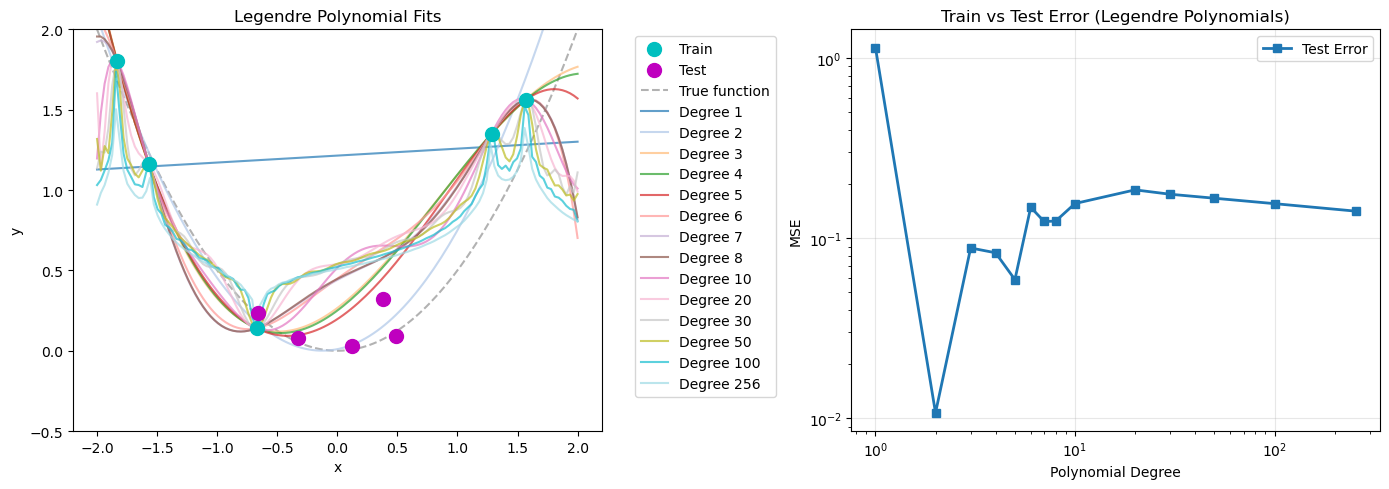

Legendre Polynomial Results:
Degree   1: Train MSE = 0.324305, Test MSE = 1.145866
Degree   2: Train MSE = 0.012458, Test MSE = 0.010725
Degree   3: Train MSE = 0.000029, Test MSE = 0.088361
Degree   4: Train MSE = 0.000000, Test MSE = 0.083069
Degree   5: Train MSE = 0.000000, Test MSE = 0.058944
Degree   6: Train MSE = 0.000000, Test MSE = 0.148667
Degree   7: Train MSE = 0.000000, Test MSE = 0.123988
Degree   8: Train MSE = 0.000000, Test MSE = 0.124549
Degree  10: Train MSE = 0.000000, Test MSE = 0.155973
Degree  20: Train MSE = 0.000000, Test MSE = 0.185771
Degree  30: Train MSE = 0.000000, Test MSE = 0.175632
Degree  50: Train MSE = 0.000000, Test MSE = 0.166913
Degree 100: Train MSE = 0.000000, Test MSE = 0.155736
Degree 256: Train MSE = 0.000000, Test MSE = 0.141452


In [8]:
import scipy.special

def fit_legendre_pinv(x_train, y_train, degree, x_min=-2, x_max=2):
    """Fit Legendre polynomial using pseudoinverse"""
    # Rescale x to [-1, 1]
    x_scaled = 2 * (x_train - x_min) / (x_max - x_min) - 1
    
    feature_degrees = np.arange(degree + 1)[:, None]
    X_train_poly = scipy.special.eval_legendre(feature_degrees, x_scaled).T
    beta_hat = np.linalg.pinv(X_train_poly) @ y_train
    return beta_hat

def eval_legendre_poly(beta, x, degree, x_min=-2, x_max=2):
    """Evaluate Legendre polynomial with given coefficients"""
    # Rescale x to [-1, 1]
    x_scaled = 2 * (x - x_min) / (x_max - x_min) - 1
    
    feature_degrees = np.arange(degree + 1)[:, None]
    X_poly = scipy.special.eval_legendre(feature_degrees, x_scaled).T
    return X_poly @ beta

# Iterate through various polynomial degrees
degrees = [1, 2, 3, 4, 5, 6, 7, 8, 10, 20, 30, 50, 100, 256]
# degrees= [1, 5, 256]
train_errors = []
test_errors = []

# Get colormap
colors = cm.tab20(np.linspace(0, 1, len(degrees)))

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Left subplot: fits
ax1.scatter(x_train, y_train, c='c', s=100, label='Train', zorder=10)
ax1.scatter(x_test, y_test, c='m', s=100, label='Test', zorder=10)
ax1.plot(all_x, all_y, 'k--', alpha=0.3, label='True function')

for i, degree in enumerate(degrees):
    # Fit Legendre polynomial
    beta_hat = fit_legendre_pinv(x_train, y_train, degree)
    all_y_fit = eval_legendre_poly(beta_hat, all_x, degree)
    
    # Plot fit
    ax1.plot(all_x, all_y_fit, color=colors[i], label=f'Degree {degree}', alpha=0.7)
    
    # Calculate errors
    y_train_pred = eval_legendre_poly(beta_hat, x_train, degree)
    y_test_pred = eval_legendre_poly(beta_hat, x_test, degree)
    train_error = np.mean((y_train - y_train_pred)**2)
    test_error = np.mean((y_test - y_test_pred)**2)
    train_errors.append(train_error)
    test_errors.append(test_error)

ax1.set_ylim([-0.5, 2])
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_title('Legendre Polynomial Fits')
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Right subplot: errors
# ax2.plot(degrees, train_errors, 'o-', label='Train Error', linewidth=2)
ax2.plot(degrees, test_errors, 's-', label='Test Error', linewidth=2)
ax2.set_xlabel('Polynomial Degree')
ax2.set_ylabel('MSE')
ax2.set_title('Train vs Test Error (Legendre Polynomials)')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print errors
print("Legendre Polynomial Results:")
for degree, train_err, test_err in zip(degrees, train_errors, test_errors):
    print(f"Degree {degree:3d}: Train MSE = {train_err:.6f}, Test MSE = {test_err:.6f}")

- Ok yep that tracks pretty well - cool!
- Would be cool to do this with SGD too, setting aside for now though

## 3b. Legendre Polynomials with Gradient Descent (?)

## 4. ReLu Model

In [9]:
# Define 2-layer ReLU network
class TwoLayerNet(nn.Module):
    def __init__(self, hidden_size=20):
        super(TwoLayerNet, self).__init__()
        self.layer1 = nn.Linear(1, hidden_size)  # Input to hidden
        self.layer2 = nn.Linear(hidden_size, 1)  # Hidden to output
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.layer2(x)
        return x

In [10]:
# Convert data to PyTorch tensors
x_train_tensor = torch.FloatTensor(x_train).reshape(-1, 1)
y_train_tensor = torch.FloatTensor(y_train).reshape(-1, 1)
x_test_tensor = torch.FloatTensor(x_test).reshape(-1, 1)
y_test_tensor = torch.FloatTensor(y_test).reshape(-1, 1)

In [11]:
x_train_tensor

tensor([[ 1.5714],
        [-0.6721],
        [ 1.2849],
        [-1.8332],
        [-1.5694]])

In [12]:
def train_that_shit(hidden_units=4, epochs=100000, lr=1e-2, seed=5, realtime_viz=False):
    # num_epochs=100000
    # lr=1e-2
    torch.manual_seed(seed)
    train_losses=[]
    test_losses=[]
    
    model = TwoLayerNet(hidden_units)
    criterion = nn.MSELoss()
    # optimizer = optim.SGD(model.parameters(), lr=lr)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    for epoch in range(epochs):
        outputs = model(x_train_tensor)
        train_loss = criterion(outputs, y_train_tensor)
        
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
    
        if (epoch + 1) % (epochs/5) == 0:
            with torch.no_grad():
                test_outputs = model(x_test_tensor)
                test_loss = criterion(test_outputs, y_test_tensor)
            train_losses.append(train_loss.item())
            test_losses.append(test_loss.item())
            print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss.item():.4f}, Test Loss: {test_loss.item():.4f}')
    
            
            with torch.no_grad():
                all_y_hat=model(torch.tensor(all_x).float().view(-1, 1))
            if realtime_viz or epoch==epochs-1:
                plt.clf()
                fig=plt.figure(0, (6, 4))
                plt.plot(all_x, all_y, c='k')
                plt.scatter(x_train, y_train, c='c')
                plt.scatter(x_test, y_test, c='m')
                plt.plot(all_x, all_y_hat.numpy(), c='c')
                # plt.ylim([-0.5, 2])        
                # display.clear_output(wait=True)
                # display.display(plt.gcf())
    return train_losses[-1], test_losses[-1]

Epoch [20000/100000], Train Loss: 0.0082, Test Loss: 0.1683
Epoch [40000/100000], Train Loss: 0.0081, Test Loss: 0.1678
Epoch [60000/100000], Train Loss: 0.0081, Test Loss: 0.1678
Epoch [80000/100000], Train Loss: 0.0000, Test Loss: 0.1652
Epoch [100000/100000], Train Loss: 0.0000, Test Loss: 0.1652


(1.2509601687860084e-10, 0.165231391787529)

<Figure size 640x480 with 0 Axes>

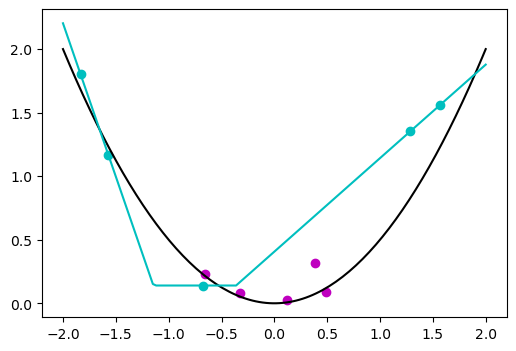

In [13]:
train_that_shit(hidden_units=2, epochs=100000, lr=1e-2, seed=5, realtime_viz=False)

Epoch [20000/100000], Train Loss: 0.0000, Test Loss: 0.1649
Epoch [40000/100000], Train Loss: 0.0000, Test Loss: 0.1652
Epoch [60000/100000], Train Loss: 0.0000, Test Loss: 0.1652
Epoch [80000/100000], Train Loss: 0.0000, Test Loss: 0.1656
Epoch [100000/100000], Train Loss: 0.0000, Test Loss: 0.1652


(1.1184386750073827e-12, 0.16522689163684845)

<Figure size 640x480 with 0 Axes>

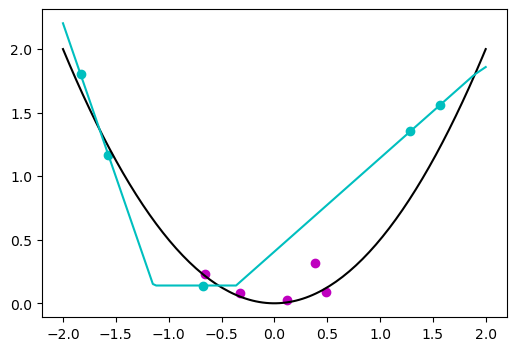

In [14]:
train_that_shit(hidden_units=3, epochs=100000, lr=1e-2, seed=5, realtime_viz=False)

Epoch [20000/100000], Train Loss: 0.0000, Test Loss: 0.1723
Epoch [40000/100000], Train Loss: 0.0000, Test Loss: 0.1789
Epoch [60000/100000], Train Loss: 0.0000, Test Loss: 0.1882
Epoch [80000/100000], Train Loss: 0.0000, Test Loss: 0.2140
Epoch [100000/100000], Train Loss: 0.0000, Test Loss: 0.2459


(2.330538393380266e-07, 0.24592359364032745)

<Figure size 640x480 with 0 Axes>

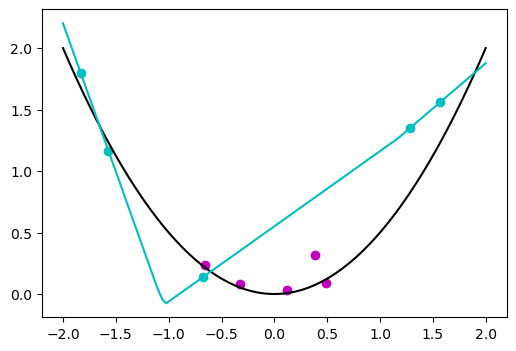

In [15]:
train_that_shit(hidden_units=4, epochs=100000, lr=1e-2, seed=5, realtime_viz=False)

Epoch [20000/100000], Train Loss: 0.0000, Test Loss: 0.2121
Epoch [40000/100000], Train Loss: 0.0000, Test Loss: 0.2400
Epoch [60000/100000], Train Loss: 0.0000, Test Loss: 0.2308
Epoch [80000/100000], Train Loss: 0.0000, Test Loss: 0.2123
Epoch [100000/100000], Train Loss: 0.0000, Test Loss: 0.1960


(2.1486648904556205e-07, 0.196041077375412)

<Figure size 640x480 with 0 Axes>

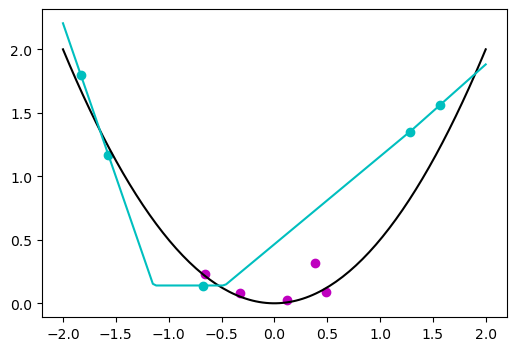

In [16]:
train_that_shit(hidden_units=5, epochs=100000, lr=1e-2, seed=5, realtime_viz=False)

Epoch [20000/100000], Train Loss: 0.0000, Test Loss: 0.1241
Epoch [40000/100000], Train Loss: 0.0000, Test Loss: 0.1409
Epoch [60000/100000], Train Loss: 0.0000, Test Loss: 0.1711
Epoch [80000/100000], Train Loss: 0.0000, Test Loss: 0.1684
Epoch [100000/100000], Train Loss: 0.0000, Test Loss: 0.1658


(2.3830908801869555e-08, 0.16577956080436707)

<Figure size 640x480 with 0 Axes>

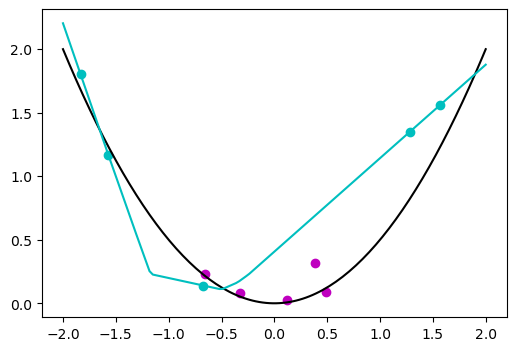

In [17]:
train_that_shit(hidden_units=10, epochs=100000, lr=1e-2, seed=5, realtime_viz=False)

Epoch [20000/100000], Train Loss: 0.0000, Test Loss: 0.1404
Epoch [40000/100000], Train Loss: 0.0000, Test Loss: 0.1658
Epoch [60000/100000], Train Loss: 0.0000, Test Loss: 0.1658
Epoch [80000/100000], Train Loss: 0.0000, Test Loss: 0.1656
Epoch [100000/100000], Train Loss: 0.0000, Test Loss: 0.1659


(2.3876011844697898e-12, 0.1659316122531891)

<Figure size 640x480 with 0 Axes>

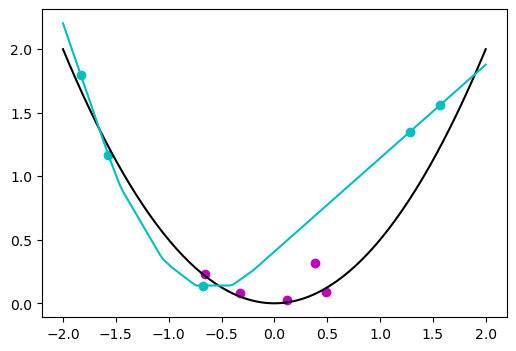

In [18]:
train_that_shit(hidden_units=20, epochs=100000, lr=1e-2, seed=5, realtime_viz=False)

Epoch [20000/100000], Train Loss: 0.0000, Test Loss: 0.1268
Epoch [40000/100000], Train Loss: 0.0000, Test Loss: 0.1767
Epoch [60000/100000], Train Loss: 0.0000, Test Loss: 0.1813
Epoch [80000/100000], Train Loss: 0.0000, Test Loss: 0.1681
Epoch [100000/100000], Train Loss: 0.0000, Test Loss: 0.1672


(0.0, 0.1671619713306427)

<Figure size 640x480 with 0 Axes>

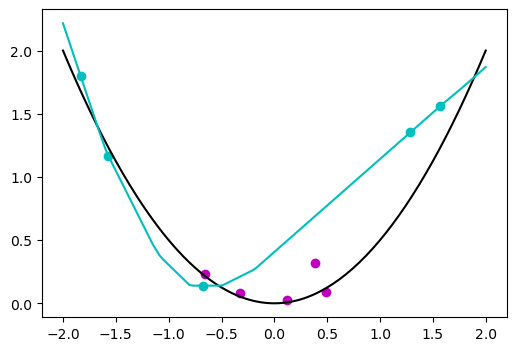

In [19]:
train_that_shit(hidden_units=100, epochs=100000, lr=1e-2, seed=5, realtime_viz=False)

Epoch [20000/100000], Train Loss: 0.0000, Test Loss: 0.0440
Epoch [40000/100000], Train Loss: 0.0000, Test Loss: 0.0440
Epoch [60000/100000], Train Loss: 0.0000, Test Loss: 0.0440
Epoch [80000/100000], Train Loss: 0.0000, Test Loss: 0.0440
Epoch [100000/100000], Train Loss: 0.0000, Test Loss: 0.0440


(0.0, 0.043994270265102386)

<Figure size 640x480 with 0 Axes>

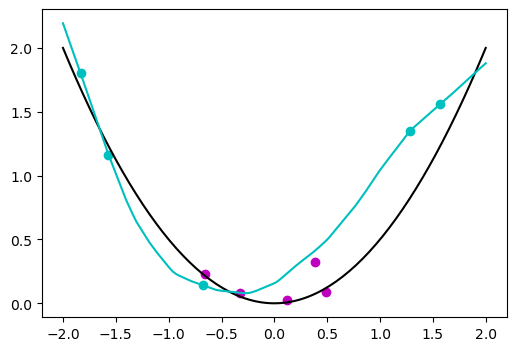

In [20]:
train_that_shit(hidden_units=100, epochs=100000, lr=1e-3, seed=5, realtime_viz=False)

Epoch [20000/100000], Train Loss: 0.0000, Test Loss: 0.0838
Epoch [40000/100000], Train Loss: 0.0000, Test Loss: 0.0838
Epoch [60000/100000], Train Loss: 0.0000, Test Loss: 0.0838
Epoch [80000/100000], Train Loss: 0.0000, Test Loss: 0.0838
Epoch [100000/100000], Train Loss: 0.0000, Test Loss: 0.0838


(0.0, 0.08381436765193939)

<Figure size 640x480 with 0 Axes>

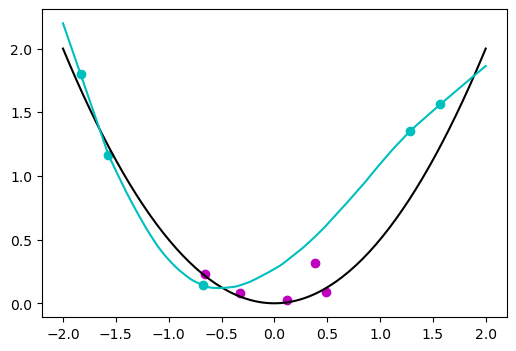

In [21]:
train_that_shit(hidden_units=1000, epochs=100000, lr=1e-2, seed=5, realtime_viz=False)

Epoch [20000/100000], Train Loss: 0.0000, Test Loss: 0.1063
Epoch [40000/100000], Train Loss: 0.0000, Test Loss: 0.1063
Epoch [60000/100000], Train Loss: 0.0000, Test Loss: 0.1063
Epoch [80000/100000], Train Loss: 0.0000, Test Loss: 0.1063
Epoch [100000/100000], Train Loss: 0.0000, Test Loss: 0.1063


(0.0, 0.10629000514745712)

<Figure size 640x480 with 0 Axes>

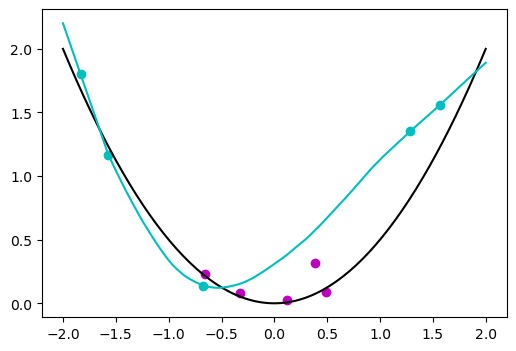

In [22]:
train_that_shit(hidden_units=1000, epochs=100000, lr=1e-3, seed=5, realtime_viz=False)